In [65]:
import pandas as pd
import numpy as np

from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold

#classifiers
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Prformance metrics
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

# from nested_cv import NestedCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

from statistics import mean

#Explainable AI
import shap

In [3]:
from sklearn.exceptions import ConvergenceWarning
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

simplefilter(action='ignore', category=ConvergenceWarning)

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize']=15,10

In [7]:
mgh = pd.read_excel('mghML.xlsx')

In [8]:
mgh_c = mgh.drop([124, 125, 126, 8, 24, 45, 59, 61, 64, 93, 97, 104, 166, 188, 192, 229, 269, 272,
            303, 60, 121, 163, 246, 46, 111, 292, 47, 201, 231, 285, 85, 193, 173])
percent_missing = mgh_c.isnull().sum() * 100 / len(mgh_c)
missing_value_df = pd.DataFrame({'column_name': mgh_c.columns,
                                 'percent_missing': percent_missing})
missing_value_df.loc[missing_value_df['percent_missing']> 0.000] 

,column_name,percent_missing


In [ ]:
def Algo_search(models , params):

    max_score = 0
    max_model = None
    max_model_params = None
    estimators_gridsearch = pd.DataFrame()
    models_est = []
    parametres = []
    lscore = []
    lroc = []
    lfscore = []
    lprecision = []
    lrecall = []
    
    scoring = {'accuracy': make_scorer(accuracy_score), 
               'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
               'f1': make_scorer(f1_score), 
               'precision': make_scorer(precision_score), 
               'recall': make_scorer(recall_score),}

    for i,j in zip(models.keys() , models.values() ):

        gs = GridSearchCV(estimator=j,param_grid=params[i], scoring=scoring, refit = "accuracy", )
        a = gs.fit(X_train,y_train)
        score = gs.score(X_test,y_test, )
        mauc = []
        mprecision = []
        mrecall = []
        mfscore = []
        maccuracy = []
        for i in range(5):
          maccuracy.append(mean(gs.cv_results_['split'+str(i)+'_test_accuracy']))
          mauc.append(mean(gs.cv_results_['split'+str(i)+'_test_roc_auc']))
          mfscore.append(mean(gs.cv_results_['split'+str(i)+'_test_f1']))
          mprecision.append(mean(gs.cv_results_['split'+str(i)+'_test_precision']))
          mrecall.append(mean(gs.cv_results_['split'+str(i)+'_test_recall']))
        models_est.append(gs.best_estimator_)
        parametres.append(gs.best_params_)
        lscore.append(round(score,2))
        lroc.append(round(mean(mauc),2))
        lfscore.append(round(mean(mfscore),2))
        lprecision.append(round(mean(mprecision),2))
        lrecall.append(round(mean(mrecall),2))

        if score > max_score:
            max_score = score
            max_model = gs.best_estimator_
            max_model_params = gs.best_params_

    estimators_gridsearch['Models'] = list(models_est)
    estimators_gridsearch['Best parameters'] = list(parametres)
    estimators_gridsearch['Score'] = list(lscore)
    estimators_gridsearch['AUC'] = list(lroc)
    estimators_gridsearch['F1-score'] = list(lfscore)
    estimators_gridsearch['Precision'] = list(lprecision)
    estimators_gridsearch['Recall'] = list(lrecall)
   

    # print(estimators_gridsearch)

    return [max_score, max_model, max_model_params], estimators_gridsearch

In [ ]:
#Data points

models = {'model_gbm':GradientBoostingClassifier(), 'model_rf':RandomForestClassifier(), 
  'model_dt':DecisionTreeClassifier(), 'model_svm':SVC(), 'model_ada':AdaBoostClassifier(), 'model_knn': KNeighborsClassifier(), 
  'model_xgb': xgb.XGBClassifier(),'model_ext': ExtraTreesClassifier(), 'model_mlp': MLPClassifier()}
params_gbm = {'learning_rate':[0.1,0.2,0.3,0.4], 'n_estimators':[50,100,500,1000,2000]}
params_rf = {'n_estimators':[50,100,500,1000,2000], 'max_depth' : [5, 10, 20], 'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]}
params_dt = {'splitter':['best','random'], 'max_depth':[1, 5, 10, 50, 100]}
params_svm = {'C':[1,2,5,10,50,100,500], 'kernel':['rbf','poly','sigmoid','linear']}
params_ada = {'n_estimators':[10,20,30,50,100,500,1000], 'learning_rate':[0.5,1,2,5,10]}
params_knn = {'n_neighbors' : [2,5,10,25,50]}
params_xgb = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}
params_ext = {'n_estimators':[50,100,500,1000,2000], 'max_depth' : [5, 10, 20], 'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]}
model_mlp = {'solver': ['lbfgs', 'sgd', 'adam'], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 
             'learning_rate':['constant','adaptive'], 'alpha': [0.0001, 0.05],
             'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)]}
params = {'model_gbm':params_gbm, 'model_rf':params_rf, 'model_dt':params_dt, 'model_svm':params_svm, 'model_ada':params_ada, 'model_knn': params_knn,
          'model_xgb':params_xgb, 'model_ext':params_ext, 'model_mlp': model_mlp}


Normalization prepocessing

In [9]:
from sklearn.preprocessing import StandardScaler


col = mgh_c.drop(['WHO max', 'KIDNEY', 'Age cat','subject_id','HEART', 'LUNG', 'DIABETES', 'IMMUNO', 'BMI cat', 'abs_neut_0_cat',
       'abs_lymph_0_cat', 'abs_mono_0_cat', 'crp_0_cat', 'ddimer_0_cat'], axis=1).columns

sc = StandardScaler()

for i in col:
    mgh_c[[i]] = sc.fit_transform(mgh_c[[i]])
 

In [70]:
X = mgh_c.drop(['WHO max'], axis=1)
y = mgh_c['WHO max']

# PCA preprocessing

In [71]:
pca = PCA(.90)
X = pca.fit_transform(X[col])
X = pd.DataFrame(X)
X['KIDNEY'] = list(mgh_c['KIDNEY'])
X['Age cat'] = list(mgh_c['Age cat'])

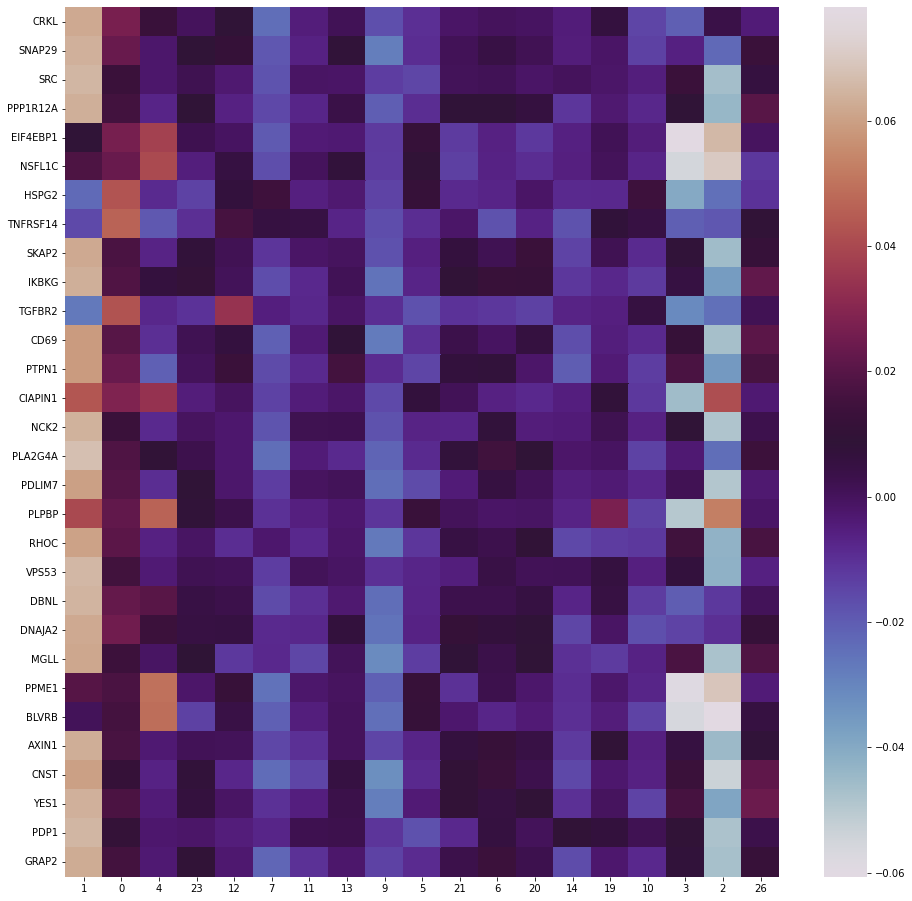

In [96]:
map= pd.DataFrame(pca.components_,columns=mgh_c[col].columns)
plt.figure(figsize=(16,16))

n_map = map[list(loadi['Proteins'])]

sns.heatmap(n_map.iloc[[1, 0, 4,23,12,7,11,13,9,5,21,6,20,14,19,10,3,2,26]].T,cmap='twilight')

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, index=mgh_c.drop(['WHO max'], axis=1)[col].columns)
loading_matrix

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
AARSD1,0.353190,0.184901,0.516124,-0.557563,0.382730,0.123875,0.035794,-0.073413,0.046925,-0.000037,...,0.021208,-0.002231,-0.002279,0.015507,0.008645,-0.000513,-0.008342,0.027543,0.000205,0.014365
ABHD14B,0.611098,0.226095,0.515620,-0.389640,0.242004,0.036695,-0.015848,0.053668,-0.008972,-0.114981,...,0.010152,0.012311,-0.005522,0.007087,-0.011252,-0.008959,0.004025,-0.020183,0.007933,0.000544
ABL1,0.747824,0.525022,-0.170954,-0.075110,-0.145483,-0.095679,-0.029628,0.026817,-0.003137,0.006851,...,0.003379,-0.015564,-0.005844,0.005139,-0.003946,-0.021641,0.008871,0.007783,0.005004,-0.019659
ACAA1,0.289654,0.405193,0.195892,0.483618,-0.138153,0.096316,0.106911,0.375541,0.116373,-0.187289,...,0.013714,0.013306,-0.039953,0.041254,0.062708,0.007863,-0.034498,-0.051554,-0.017851,-0.027343
ACAN,0.526183,-0.130978,0.013748,0.133922,-0.019901,0.028101,0.037637,-0.038102,-0.008022,0.023264,...,-0.066362,0.018308,0.004160,0.117511,0.033763,0.012926,-0.009796,0.008611,0.050449,-0.065379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YES1,0.343834,0.820083,-0.359756,0.128853,-0.030122,-0.022153,0.029587,-0.046688,0.013417,-0.112486,...,0.000692,0.019589,0.008965,0.018264,0.004645,-0.014753,0.007494,-0.010542,-0.011859,0.004568
YTHDF3,0.373714,0.598393,-0.221979,0.108294,-0.093275,-0.095468,0.033378,-0.067082,-0.019505,0.115407,...,-0.046821,0.022289,-0.001851,-0.008331,-0.047344,-0.028941,-0.043584,0.027404,0.047481,0.122256
ZBTB16,0.394524,0.749609,-0.253690,0.086040,-0.159640,-0.132924,0.079029,-0.033953,-0.091667,-0.057455,...,0.029717,0.016109,-0.004543,0.018190,-0.003879,0.035089,-0.031060,0.037121,0.021251,0.006691
ZBTB17,0.645451,0.158919,0.515556,0.013978,-0.015615,-0.118662,-0.053355,0.052573,0.202670,0.175993,...,0.005134,0.006417,0.012014,-0.002386,0.009686,-0.040091,-0.009795,0.015912,-0.009114,-0.002013


In [ ]:
load_trans = loading_matrix.T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowMGH.xlsx')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [ ]:
grid_mX_pca, grid_ml_pca = Algo_search(models = models, params = params)

grid_ml_pca

# Explainable AI

In [ ]:
clf = MLPClassifier(activation= 'logistic',
hidden_layer_sizes= (50, 50, 50),
alpha= 0.0001,
learning_rate= 'adaptive',
solver= 'lbfgs'
)

clf.fit(X, y)

explainer = shap.KernelExplainer(clf.predict,X)
shap_values = explainer.shap_values(X_test)

Using 272 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/55 [00:00<?, ?it/s]

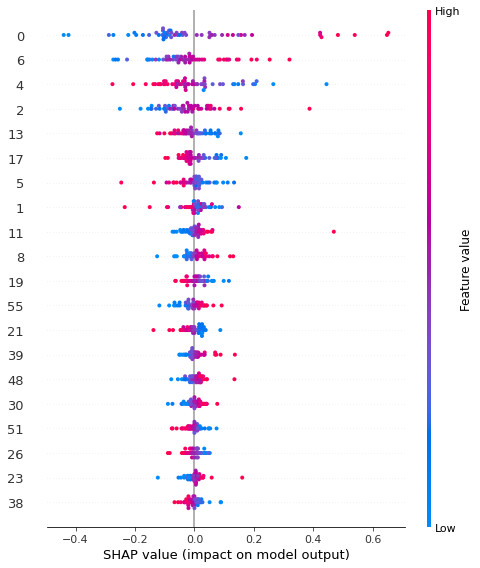

In [ ]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values,X_test,feature_names=X.columns, max_display =20,show=False )
plt.savefig('mlp_xai_mgh.svg')

In [ ]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.to_excel('mgh_mlp_xai.xlsx')

In [ ]:
load_trans = loading_matrix[list(feature_importance['col_name'])[:21]].T
magnitude = 0
loading_pow = {}
for i in load_trans.columns:
  magnitude = load_trans[i].pow(2).sum()
  loading_pow[i] = magnitude

pd.DataFrame.from_dict(loading_pow, orient='index').to_excel('loadingspowMGHmpl.xlsx')